<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DiT/Inference_with_DiT_(Document_Image_Transformer)_for_document_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

We first install 🤗 Transformers and Datasets.

In [233]:
!pip install -q transformers datasets

## Load data

I've prepared a little demo dataset on the hub, which includes 15 images of the [RVL-CDIP](https://www.cs.cmu.edu/~aharley/rvl-cdip/) dataset (one image per class, excluding the handwritten class). This dataset was created using Datasets' awesome `ImageFolder` [feature](https://huggingface.co/docs/datasets/master/en/loading#image-folders), after which it was pushed to the hub using `push_to_hub`.

In [237]:
from datasets import load_dataset

dataset = load_dataset("nielsr/rvlcdip-demo")

Downloading:   0%|          | 0.00/943 [00:00<?, ?B/s]

Using custom data configuration nielsr--rvlcdip-demo-4789848c9cd54eef


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/nielsr--rvlcdip-demo-4789848c9cd54eef/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

The awesome thing about image datasets on the hub, is that the image column is of type "Image", which can be directly displayed in a notebook (🤯) like so:

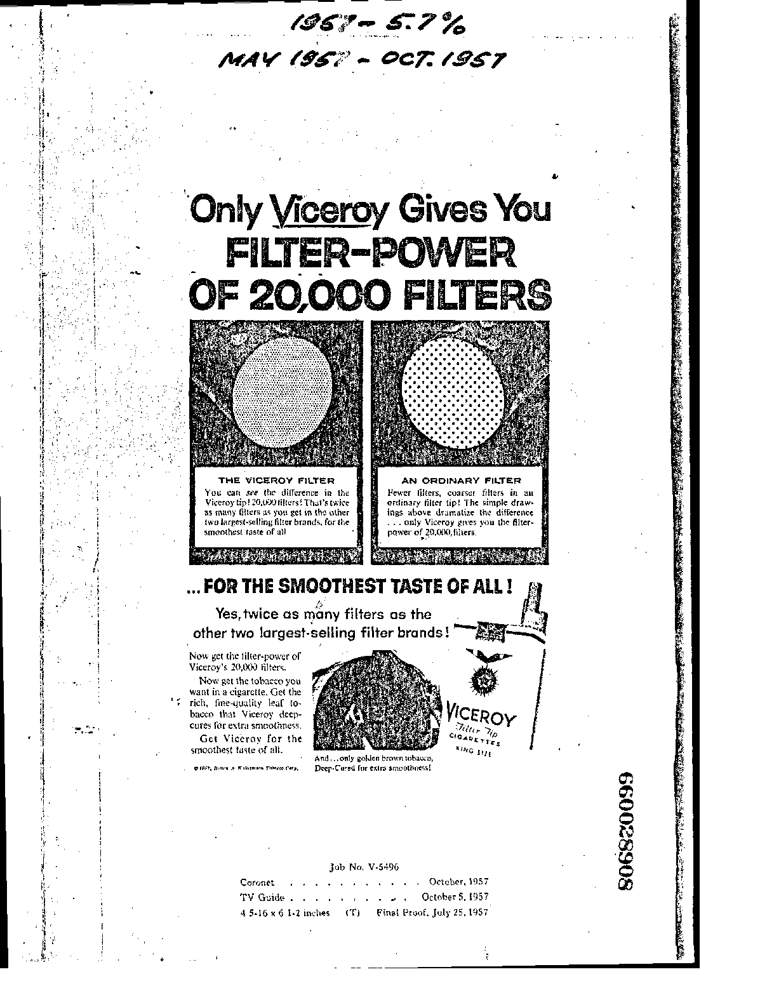

In [238]:
dataset['train'][0]['image']

We can see that the corresponding label is "4". Hmm that's not really helpful.. which class would this be?

In [239]:
dataset['train'][0]['label']

4

Let's check the features of this dataset:

In [253]:
dataset['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=16, names=['letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication', 'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume', 'memo'], id=None)}

As we can see, the "label" column is of type `ClassLabel`. We can now check the label of hte image, as follows:

In [256]:
labels = dataset['train'].features['label'].names
print(labels[4])

advertisement


So the image above is labeled as an "advertisement". Seems correct!

## Inference

Let's load the DiT model, fine-tuned on the RVL-CDIP dataset, from the hub and make a prediction. 

We also load the feature extractor, useful for preparing images for the model.

In [241]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")
model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")

Downloading:   0%|          | 0.00/302 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/327M [00:00<?, ?B/s]

Let's prepare the image for the model and run a forward pass!

In [244]:
import torch

image = dataset['train'][0]['image'].convert("RGB")

# prepare image for model (resize + normalize)
inputs = feature_extractor(image, return_tensors="pt")

# forward pass
with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

# model predicts one of the 16 RVL-CDIP classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: advertisement


Seems like the model got it correct ;)

## Evaluate

Now that we've shown inference on a single image, let's use the model to run predictions on the entire (tiny) dataset. For this, we create a PyTorch DataLoader, which lets us easily loop over batches.

We first prepare (i.e. resize + normalize) all images using the feature extractor. For this, we can use the .map() functionality, which lets us apply any custom function on all instances of a dataset.

In [245]:
from datasets import Features, Array3D

# we need to define the features ourselves as set_format won't work otherwise
features = Features({
    **dataset['train'].features,
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224))
})

encoded_dataset = dataset.map(lambda examples: feature_extractor([image.convert('RGB') for image in examples['image']]), batched=True,
                              features=features)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [246]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 15
    })
})

Next, we create a PyTorch DataLoader.

In [247]:
encoded_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
dataloader = torch.utils.data.DataLoader(encoded_dataset['train'], batch_size=2)

Let's verify the first batch:

In [248]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

label torch.Size([2])
pixel_values torch.Size([2, 3, 224, 224])


Let's evaluate the model on this tiny dataset!

In [258]:
from datasets import load_metric
from tqdm.notebook import tqdm

metric = load_metric("accuracy")

for batch in tqdm(dataloader):
  with torch.no_grad():
    outputs = model(batch['pixel_values'])
    logits = outputs.logits
  
  metric.add_batch(predictions=logits.argmax(-1).tolist(), references=batch['label'].tolist())

accuracy = metric.compute()['accuracy']

print("Accuracy on this tiny dataset:", accuracy)

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy on this tiny dataset: 0.8666666666666667
